In [128]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

In [95]:
dh_data = pd.read_csv('ALL_DH_stats.csv').groupby('PLAYER').max()
salaries = pd.read_csv('salaries.csv')

In [96]:
def expand_years(row):
    years_info = row['years']
    num_years, year_range = years_info.split(' (')
    year_range = year_range.rstrip(')')
    years = year_range.split('-') if '-' in year_range else [year_range]
    expanded_rows = []
    for year in years:
        new_row = row.copy()
        new_row['years'] = year
        expanded_rows.append(new_row)
    return expanded_rows

# Apply the function to each row and concatenate the results
salary_df = pd.DataFrame([item for sublist in salaries.apply(expand_years, axis=1) for item in sublist])

# Reset index to clean up the dataframe
salary_df.reset_index(drop=True, inplace=True)

salary_df["years"] = salary_df["years"].astype(int)
salary_df.rename(columns={'name': 'PLAYER', 'years': 'year'}, inplace=True)

combined_df = pd.merge(dh_data, salary_df, on=["PLAYER", "year"], how="inner")

In [97]:
def convert_money_string(money):
    return money.replace('$', '').replace(',', '').replace(' ', '')
combined_df['salary'] = combined_df['salary'].apply(convert_money_string).astype(int)
high_value_dh = combined_df[combined_df["salary"] >= int(combined_df["salary"].quantile(0.9))].drop("salary", axis=1)
low_value_dh = combined_df[combined_df["salary"] <= int(combined_df["salary"].quantile(0.1))].drop("salary", axis=1)
high_value_dh = high_value_dh.assign(valuable=True)
low_value_dh = low_value_dh.assign(valuable=False)
truth_set = pd.concat([high_value_dh, low_value_dh])
combined_df = combined_df.drop("salary", axis=1)

In [98]:
truth_set.columns

Index(['PLAYER', 'Unnamed: 0', 'TEAM', 'G', 'AB', 'R', 'H', '2B', '3B', 'HR',
       'RBI', 'BB', 'SO', 'SB', 'CS', 'AVG', 'OBP', 'SLG', 'OPS', 'year',
       'index', 'total_value', 'pos', 'avg_annual', 'team', 'valuable'],
      dtype='object')

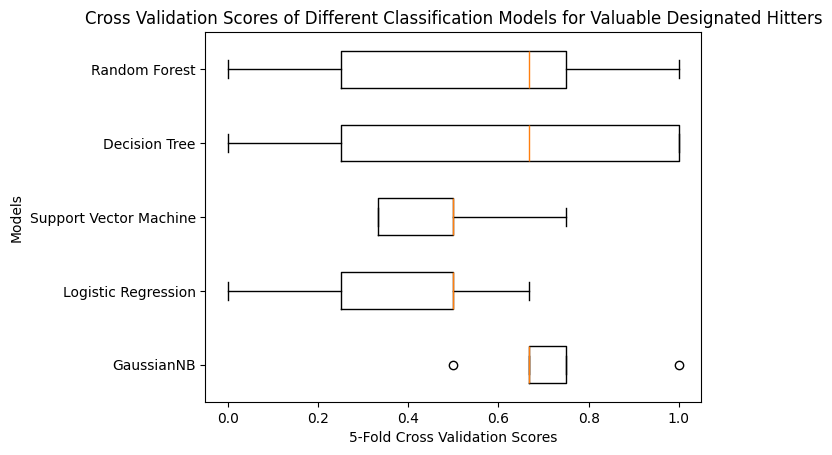

In [147]:
# train model on the set of known value (statistically significant salaries

feature_columns = ['G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'BB', 'SO', 'SB', 'CS', 'AVG', 'OBP', 'SLG', 'OPS']
target_columns = "valuable"
categorical_features = truth_set[feature_columns].select_dtypes(include=['object']).columns

feature_columns = [x for x in feature_columns if x not in categorical_features]

X = truth_set[feature_columns]
y = truth_set[target_columns]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

models = {
    'GaussianNB': GaussianNB(),
    'Logistic Regression': LogisticRegression(max_iter=10000),
    'Support Vector Machine': SVC(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier()
}

cvs = []

for name, model in models.items():
    cv_scores = cross_val_score(model, X, y, cv=5)  # 5-fold cross-validation
    cvs.append(cv_scores)

fig, ax = plt.subplots()

ax.boxplot(
    cvs,
    vert=False,
    tick_labels=models.keys(),
)
ax.set_title('Cross Validation Scores of Different Classification Models for Valuable Designated Hitters')
ax.set_xlabel('5-Fold Cross Validation Scores')
ax.set_ylabel('Models')
plt.show()

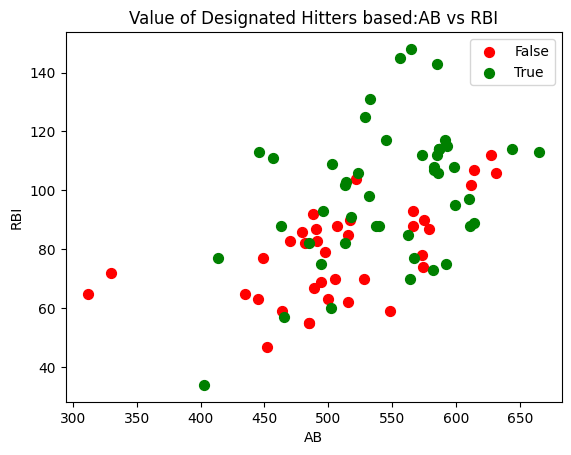

In [113]:
# plot results
x_feature = "AB"
y_feature = "RBI"
y_pred = gnb.predict(combined_df[feature_columns].fillna(0))

cdict = {0: 'red', 1: 'green'}

plot_df = combined_df.copy()
plot_df.insert(len(combined_df.columns), "valuable", y_pred)

for g in [False, True]:
    class_data = plot_df[plot_df["valuable"] == g]
    plt.scatter(class_data[x_feature], class_data[y_feature], c = cdict[g], label = g, s = 50)

plt.title("Value of Designated Hitters based:" + x_feature + " vs " + y_feature)
plt.xlabel(x_feature)
plt.ylabel(y_feature)
plt.legend()
plt.show()

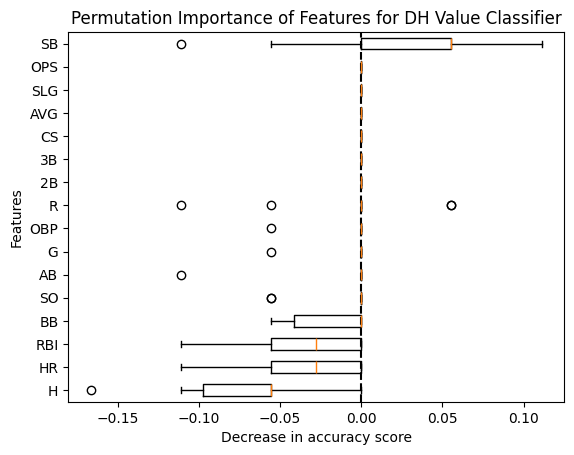

In [115]:
# determine feature importance

from sklearn.inspection import permutation_importance

imps = permutation_importance(gnb, X_test, y_test)
def plot_permutation_importance(clf, X, y, ax):
    result = permutation_importance(clf, X, y, n_repeats=10, random_state=42, n_jobs=2)
    perm_sorted_idx = result.importances_mean.argsort()

    ax.boxplot(
        result.importances[perm_sorted_idx].T,
        vert=False,
        tick_labels=X.columns[perm_sorted_idx],
    )
    ax.axvline(x=0, color="k", linestyle="--")
    return ax
fig, ax = plt.subplots()
ax.set_xlabel("Decrease in accuracy score")
ax.set_ylabel("Features")
ax.set_title("Permutation Importance of Features for DH Value Classifier")
plot_permutation_importance(gnb, X, y, ax)
plt.show()

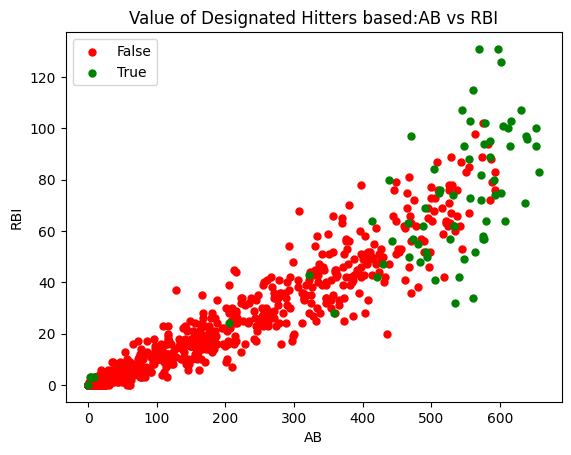

In [160]:
# use classifier to evaluate general baseball population
full_df = pd.read_csv('Final_MLB_Data.csv')
full_df.rename(columns={'BA': 'AVG'}, inplace=True)
value = gnb.predict(full_df[feature_columns])

full_plot_df = full_df.copy()
full_plot_df.insert(len(combined_df.columns), "valuable", value)

for g in [False, True]:
    class_data = full_plot_df[full_plot_df["valuable"] == g]
    plt.scatter(class_data[x_feature], class_data[y_feature], c = cdict[g], label = g, s = 25)

plt.title("Value of Designated Hitters based:" + x_feature + " vs " + y_feature)
plt.xlabel(x_feature)
plt.ylabel(y_feature)
plt.legend()
plt.show()